In [1]:
import cmdstanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
import os

# Set working directory using os.chdir(path to directory)
os.chdir('..')  # Adjust the path as necessary

# check current working directory
if not os.getcwd().endswith('population_growth_perturbations'):
    raise RuntimeError("Current directory: {}".format(os.getcwd()) + ". Please set the working directory to the 'population_growth_perturbations' folder.")

/Users/sanket/Desktop/Work/QI2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fix for macOS C++ compilation issues with CmdStan
# Set SDK paths to resolve standard library header issues
import subprocess
sdk_result = subprocess.run(['xcrun', '--show-sdk-path'], capture_output=True, text=True)
sdk_path = sdk_result.stdout.strip()
os.environ['SDKROOT'] = sdk_path

# install cmdstan if not already installed
if not cmdstanpy.cmdstan_path():
    cmdstanpy.install_cmdstan()
    

In [3]:
# Load the data
data = pd.read_csv('datasets/observed_data.csv')

# Compile the Stan model (make sure to point to the correct Stan file)
model = cmdstanpy.CmdStanModel(stan_file='stan_models/simple_homogeneous_model.stan') 

In [4]:
# Prepare data for Stan (adjust based on your data structure)
stan_data = {
    't0': 10,         # Initial time
    'y0': data['cell_counts'].values[0],       # Initial observed value
    'y_obs': data['cell_counts'].values[1:].tolist(),  # Observed values -- drop first time point since it's initial condition
    'time_obs': data['time'].values[1:].tolist(),  # Observation times -- drop first time point
    'T': len(data) - 1,  # Number of time points (exclude initial condition)
}

# Fit the model --- run chains in parallel
fit = model.sample(data=stan_data, chains=4, parallel_chains=4, iter_sampling=500, show_progress=False, iter_warmup=300) # some exceptions may occur here depending on data structure and model priors

07:45:16 - cmdstanpy - INFO - CmdStan start processing
07:45:16 - cmdstanpy - INFO - Chain [1] start processing
07:45:16 - cmdstanpy - INFO - Chain [2] start processing
07:45:16 - cmdstanpy - INFO - Chain [3] start processing
07:45:16 - cmdstanpy - INFO - Chain [4] start processing
07:45:16 - cmdstanpy - INFO - Chain [3] done processing
07:45:16 - cmdstanpy - INFO - Chain [2] done processing
07:45:17 - cmdstanpy - INFO - Chain [4] done processing
07:45:17 - cmdstanpy - INFO - Chain [1] done processing
07:45:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ode_rk45: ode parameters and data[1] is inf, but must be finite! (in 'simple_homogeneous_model.stan', line 46, column 4 to column 89)
	Exception: ode_rk45: ode parameters and data[1] is inf, but must be finite! (in 'simple_homogeneous_model.stan', line 46, column 4 to column 89)
Exception: ode_rk45: ode parameters and data[1] is inf, but must be finite! (in 'simple_homogeneous_model.stan', line 46, column 4 to co

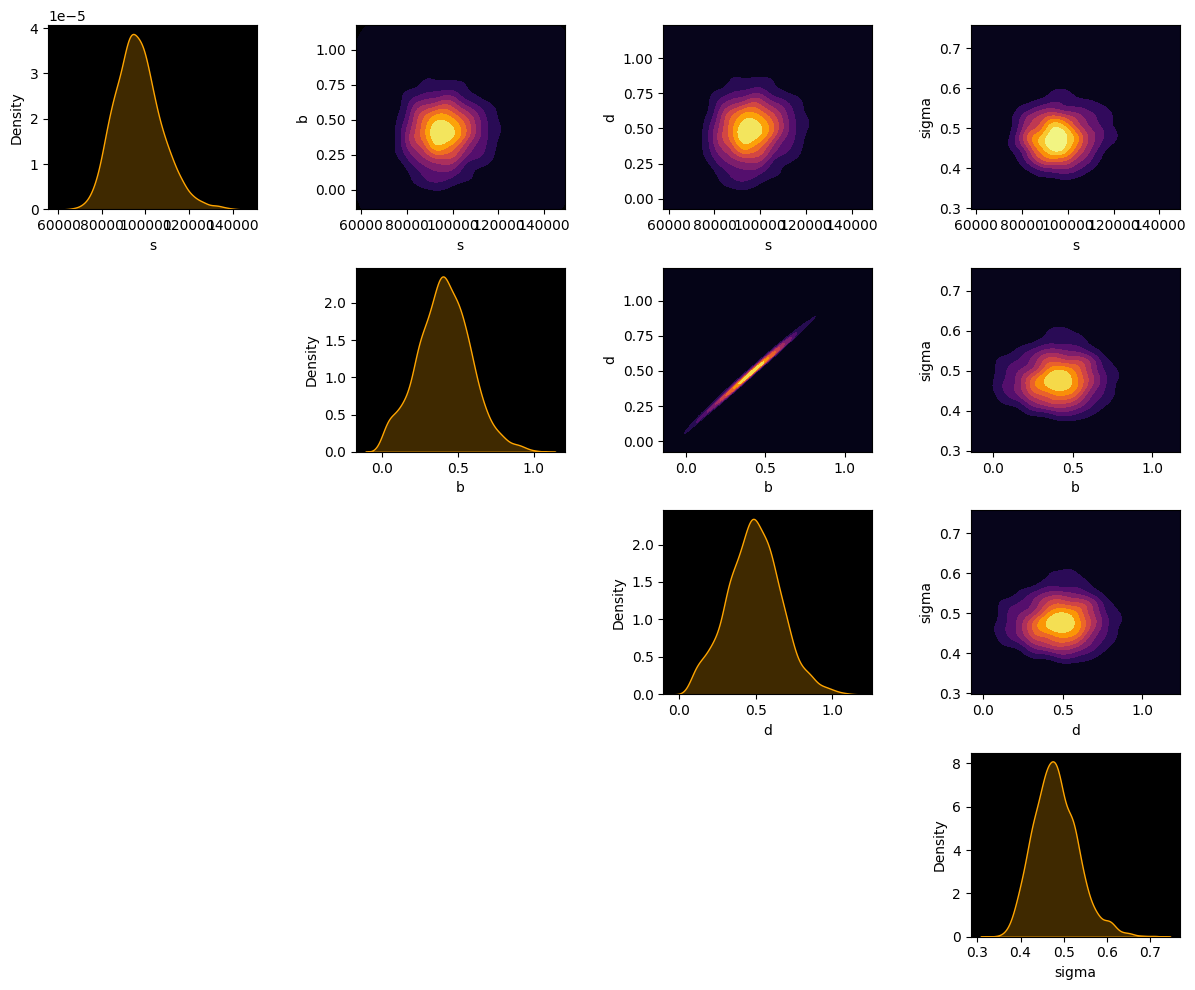

In [5]:
# extract posterior samples
posterior = fit.draws_pd()

# parameter names based on the Stan model
param_names = ['s', 'b', 'd', 'sigma']

# plot bivariate distribution for all parameters
fig, axes = plt.subplots(len(param_names), len(param_names), figsize=(12, 10))
for i in range(len(param_names)):
    for j in range(len(param_names)):
        axes[i, j].set_facecolor('black')  # Set axes background to black
        if i == j:
            sns.kdeplot(x=posterior[param_names[i]], ax=axes[i, j], fill=True, color='orange')
            axes[i, j].set_xlabel(param_names[i])
            axes[i, j].set_ylabel('Density')
        elif i < j:
            sns.kdeplot(x=posterior[param_names[i]], y=posterior[param_names[j]], fill=True, cmap='inferno', thresh=0, levels=10, ax=axes[i, j])
            axes[i, j].set_xlabel(param_names[i])
            axes[i, j].set_ylabel(param_names[j])
        else:
            axes[i, j].axis('off')
plt.tight_layout()
plt.show()

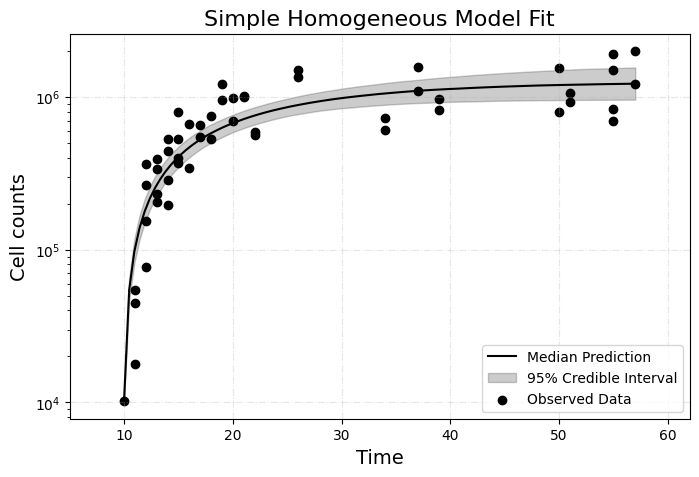

In [6]:
# solve exponential ode using posterior samples
y_pred_samples = []

time_points = np.linspace(10, data['time'].max(), 100)
model_params = (posterior['s'], posterior['b'], posterior['d'])

for i in range(len(posterior['s'])):
    s = posterior['s'][i]
    b = posterior['b'][i]
    d = posterior['d'][i]

    def model_ode(y, t):
        dydt = s + b * y - d * y
        return dydt
    y0_val = data['cell_counts'].values[0]
    y_pred = odeint(model_ode, y0_val, time_points)
    y_pred_samples.append(y_pred.flatten())

# Plot results using seaborn
plt.figure(figsize=(8, 5))
sns.lineplot(x=time_points, y=np.median(y_pred_samples, axis=0), color='black', label='Median Prediction')
plt.fill_between(time_points,
                 np.percentile(y_pred_samples, 2.5, axis=0),
                 np.percentile(y_pred_samples, 97.5, axis=0),
                 color='black', alpha=0.2, label='95% Credible Interval')
plt.scatter(data['time'], data['cell_counts'], color='black', label='Observed Data')
plt.xlabel('Time', fontsize=14)
plt.xlim(5, 62)
plt.yscale('log')
plt.ylabel('Cell counts', fontsize=14)
plt.title('Simple Homogeneous Model Fit', fontsize=16)
plt.legend()
plt.grid(alpha=0.3, linestyle='-.')

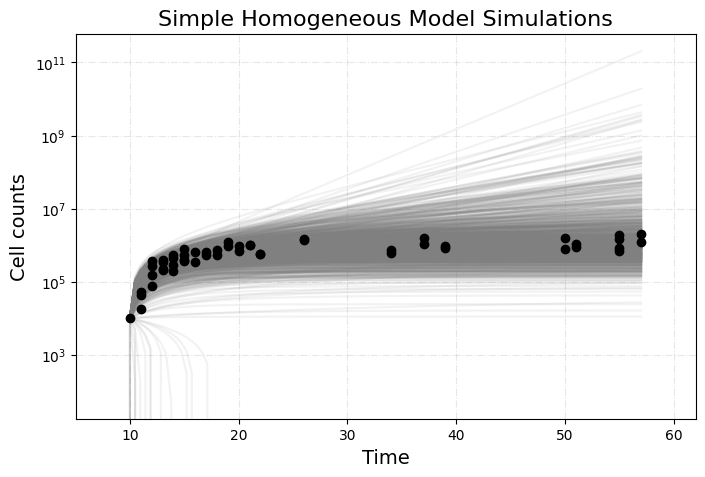

In [72]:
# plot independent curves for a few posterior samples
seed = 42
np.random.seed(seed)


y_pred2_samples = []
s_prior = np.random.normal(loc=1e5, scale=5e4, size=1000)
b_prior = np.random.normal(loc=0.4, scale=0.05, size=1000)
d_prior = np.random.normal(loc=0.5, scale=0.1, size=1000)

for i in range(1000):
    s = s_prior[i]
    b = b_prior[i]
    d = d_prior[i]

    def model_ode(y, t):
        dydt = s + b * y - d * y
        return dydt
    y0_val = data['cell_counts'].values[0]
    y_pred = odeint(model_ode, y0_val, time_points)
    y_pred2_samples.append(y_pred.flatten())


plt.figure(figsize=(8, 5))
# bring observed data points to front
plt.scatter(data['time'], data['cell_counts'], color='black', zorder=10)
for i in range(1000):
    plt.plot(time_points, y_pred2_samples[i], color='gray', alpha=0.1)
plt.xlabel('Time', fontsize=14)
plt.xlim(5, 62)
plt.yscale('log')
plt.ylabel('Cell counts', fontsize=14)
plt.title('Simple Homogeneous Model Simulations', fontsize=16)
plt.grid(alpha=0.3, linestyle='-.')


In [ ]:
# Print summary
print(fit.summary())

In [ ]:
# Life expectancy, R0, Source influx calculations and visualization

s_median = np.median(posterior['s'])
d_median = np.median(posterior['d'])

lexp = np.percentile(1/posterior['d'], [2.5, 50, 97.5])  # Life expectancy with 95% credible interval
r0 = np.percentile(posterior['b'] / (posterior['d']), [2.5, 50, 97.5])  # Basic reproduction number with 95% credible interval
infl = np.percentile(posterior['s'], [2.5, 50, 97.5])  # Infection number with 95% credible interval

# font sizes
plt.rcParams.update({'font.size': 12})


# plot life expectancy, r0, infl as scatter plots with error bars as subplots
fig, ax = plt.subplots(1, 3, figsize=(8, 5))
ax[0].errorbar(1, lexp[1], yerr=[[lexp[1]-lexp[0]], [lexp[2]-lexp[1]]], fmt='o', color='#107A9E', capsize=5)
ax[0].set_title('Life Expectancy', fontsize=14)
ax[0].set_ylabel('Time Units', fontsize=14)
ax[0].set_xticks([])
ax[0].set_ylim(0,10)
ax[1].errorbar(1, r0[1], yerr=[[r0[1]-r0[0]], [r0[2]-r0[1]]], fmt='o', color='#EAAA00', capsize=5)
ax[1].set_title('R0', fontsize=14)
ax[1].set_xticks([])
ax[1].set_ylim(0,1)
ax[2].errorbar(1, infl[1], yerr=[[infl[1]-infl[0]], [infl[2]-infl[1]]], fmt='o', color='black', capsize=5)
ax[2].set_title('Influx', fontsize=14)
ax[2].set_xticks([])
ax[2].set_yscale('log')
ax[2].set_ylim(5e4, 3e5)
ax[2].set_ylabel('Cell Counts', fontsize=14)
plt.tight_layout()